In [1]:
import os
from PIL import Image
# from transformers import CLIPProcessor, CLIPModel
import torch
import json
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# # Initialize CLIP model and processor
# model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")


In [2]:
image_folder_path = "yars_data/photos"

# # Load images and preprocess them
# embeddings = []
# for image_name in os.listdir(image_folder_path):
#     image_path = os.path.join(image_folder_path, image_name)
#     image = Image.open(image_path).convert("RGB")
#     inputs = processor(images=image, return_tensors="pt")
#     outputs = model.get_image_features(**inputs)
#     embeddings.append(outputs)

embeddings_tensor = torch.load("yars_data/base_out/features.pt")

embeddings_numpy = embeddings_tensor.cpu().detach().numpy()

if len(embeddings_numpy.shape) > 2:
    embeddings_numpy = embeddings_numpy.reshape(embeddings_numpy.shape[0], -1)

In [3]:
paths  = open("yars_data/base_out/paths.txt").read().split("\n")[1:]
# paths

In [4]:
from sklearn.cluster import DBSCAN

# eps is the maximum distance between two points for them to be considered as in the same neighborhood
# min_samples is the minimum number of points required to form a dense region, which DBSCAN considers as a cluster
# these need to be change for different dataset
dbscan = DBSCAN(eps=6, min_samples=2).fit(embeddings_numpy)

dbscan_labels = dbscan.labels_

num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Number of clusters found: {num_clusters}")

print(dbscan_labels)


Number of clusters found: 337
[-1  0  0 ...  0  0  0]


In [5]:
# Assign images to clusters (skip -1 label, noise)
cluster_images = {}
for idx, label in enumerate(dbscan_labels):
    label = str(label)
    if label != "-1":
        if label not in cluster_images:
            cluster_images[label] = []
        cluster_images[label].append(paths[idx])

with open("clusters.json", 'w') as file:
    json.dump(cluster_images, file)

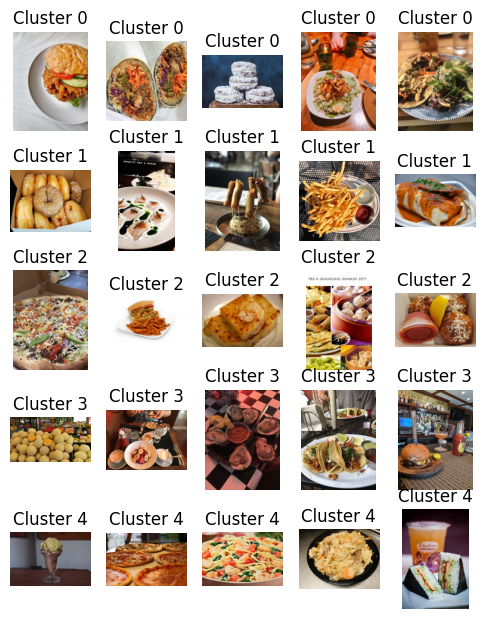

In [6]:
count = 0
clusters_to_show = 5
fig, ax = plt.subplots(clusters_to_show, 5, figsize=(6, 1.5 * clusters_to_show))
for cluster, images in cluster_images.items():
        
    # more than one
    if len(images) >= 5:

        for i, image_name in enumerate(images[:5]):
            image_path = os.path.join(image_folder_path, image_name)
            image = Image.open(image_path)
            ax[count][i].imshow(image)
            ax[count][i].set_title(f'Cluster {count}')
            ax[count][i].axis('off')

        count += 1
        if count == clusters_to_show:
            break

plt.show()